In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.distributions import bijector

from tensorflow.contrib.distributions import Normal
from tensorflow.python.ops import nn
from pymisca.transformed_distribution import TransformedDistribution
# array_ops.gather_nd?

/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
%matplotlib inline 

is in ipython: 1
is in ipython: 1
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
[WARN] pymisca.vis_util cannot find network


is in ipython: 1
[WARN] pymisca.vis_util cannot find network


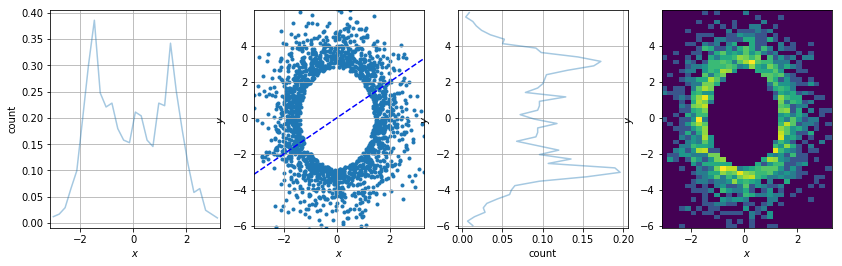

In [3]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
%matplotlib inline 


D = 2


TRUE_MU = 0.0
TRUE_SIGMA = 2.0
SAMPLE_SIZE = (5000,D)

np.random.seed(0)
x_obs = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=SAMPLE_SIZE)
rsq = np.square(x_obs).sum(axis=-1)

keep = rsq > np.mean(rsq)
x_obs = x_obs[keep]

#### Random Linear transformation
# C = pyutil.random_covmat()
# x_obs = x_obs.dot(C)

#### Make an ellipse
x_obs.T[0] *= 0.5

# x_obs = np.square(x_obs)
pyvis.qc_2var(x_obs.T[0],x_obs.T[1])

In [4]:
import pymisca.tensorflow_extra as pytf
reload(pytf)




from tensorflow.python.ops import nn
import tensorflow as tf

# data
x = tf.placeholder(dtype=tf.float32)

INIT_MU_PARAMS = {'loc': 0.0, 'scale': 0.1}
INIT_PHI_PARAMS = {'loc': 1.0, 'scale': 0.1}
RANDOM_SEED = 0

# params
np.random.seed(RANDOM_SEED)
mu = 1. + nn.softplus(tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                 dtype=tf.float32)
                )
phi =nn.softplus( tf.Variable(initial_value=np.random.normal(**INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )
sigma =nn.softplus( tf.Variable(initial_value=np.random.normal(size=(D,),
                                                               **INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )

# sigma = tf.square(phi)

# loss

def makeEMD( (mu,phi,sigma) ):
    dist_rsq = tf.contrib.distributions.Gamma(concentration=mu,rate=phi)

    #### Use a bijector to calculate P(x) from P(r^2)
    dist_xyz = mdl = pytf.AsRadial(distribution=dist_rsq,
                                   D=D)
    
    ### Allow an affine transformation y = M x + x_0
#     dist_aff = mdl = pytf.AffineTransformDiag(distribution=dist_xyz,
#                                         scale_diag=sigma,)
    
    
    # gaussian_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
    # mdl  = dist_rsq
    return mdl


fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)


Xmd = np.random.random((100,200,D)).astype(np.float32)
bjt = emission.bijector
# bjt = emission.distribution.bijector
xTheta = bjt.inverse(Xmd)
print (xTheta.shape)

fldj =val= bjt.forward_log_det_jacobian(xTheta,event_ndims=1)
print (val.shape,)

ildj = bjt.inverse_log_det_jacobian(Xmd,event_ndims=1,)
print (val.shape)


# assert 0

[WARN]unable to import edward.models
[WARN]unable to import edward.models
(100, 200)
(100,)
(100,)


In [5]:
from tensorflow_probability.python import bijectors
bijectors.Bijector

tensorflow.python.ops.distributions.bijector_impl.Bijector

In [6]:
from tensorflow_probability import bijectors
# bijectors.AffineLinearOperator.inverse_log_det_jacobian?

In [7]:
fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)
log_prob = emission.log_prob(value=x)
neg_log_likelihood = -1.0 * tf.reduce_sum(log_prob)


# gradient
free_vars = [mu,phi,sigma]
grad = tf.gradients(neg_log_likelihood, free_vars)

In [8]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/
reload(pytf)
LEARNING_RATE = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
sess,last_vars, hist_loss, opt = pytf.op_minimise(
    neg_log_likelihood,
    fitted_vars,
    optimizer,
    feed_dict = {x: x_obs}
)

[WARN]unable to import edward.models
Iter 0 20736.19
Iter 100 7859.744
Iter 200 7853.7607
Loss function convergence in 268 iterations!: 7853.2578125


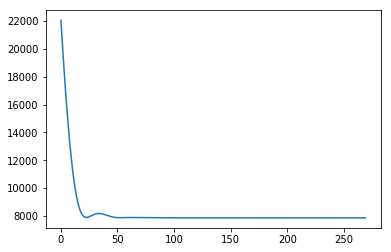

In [9]:
import pymisca.vis_util as pyvis
%matplotlib inline 

plt = pyvis.plt
plt.plot(hist_loss)

In [10]:
print (last_vars)

[2.6314518, 0.27431878, array([1.3857405, 1.481847 ], dtype=float32)]


In [11]:
with sess.as_default():
    print ([x.eval() for x in emission.distribution._graph_parents])

[2.6314518, 0.27431878]


Instructions for updating:
dim is deprecated, use axis instead


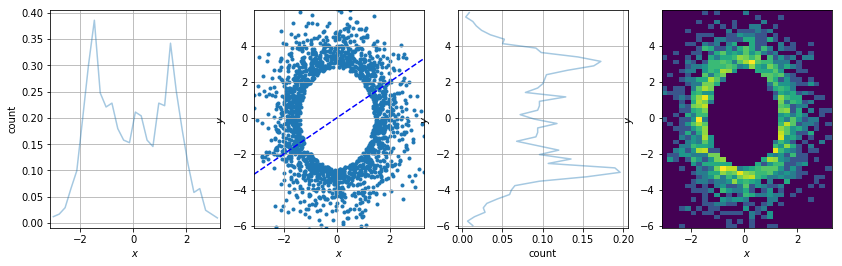

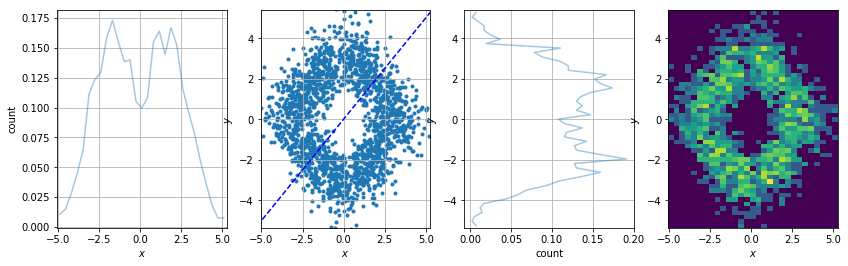

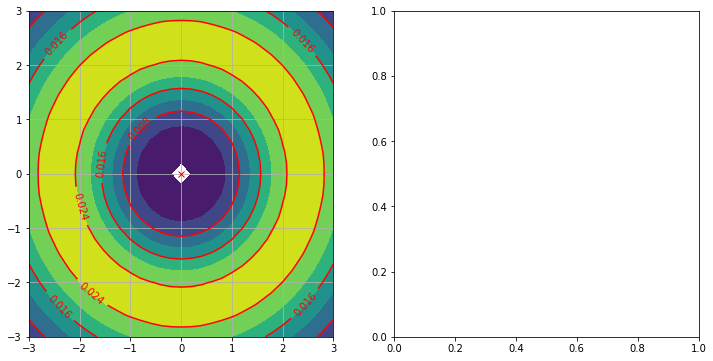

In [12]:
with sess.as_default():
# sess = tf.InteractiveSession()
# if 1:
    EMD = makeEMD(last_vars)
    X = x_obs.astype(np.float32)
    Y = EMD.sample(len(X)).eval()
    L = EMD.log_prob(X).eval()
    pyvis.qc_2var(X.T[0],X.T[1])
    pyvis.qc_2var(Y.T[0],Y.T[1])
    
    f = EMD.prob
    L = f(X).eval()
#     f = emission.distribution.distribution.prob
    f = pyutil.wrapTFmethod(f,sess=sess)
    f = pyutil.arrayFunc2mgridFunc(f)
    pyvis.dmet_2d(f,vectorised=1,span=[-3,3]);
    
#     Z = EMD.bijector.inverse(X).eval()
#     pyvis.qc_2var(Z.T[0],Z.T[1])

[-1.1447299 -1.1447299 -1.1447299 ... -1.1447299 -1.1447299 -1.1447299]
(1867,) (1867,)
[ 3.752384  21.044334   7.3080616 ... 13.695565  18.443056  14.0620365]
[ 3.752384  21.044336   7.308061  ... 13.695566  18.443056  14.0620365]
[1.1447299 1.1447299 1.1447299 ... 1.1447299 1.1447299 1.1447299]
[-3.801615  -5.732107  -3.6894999 ... -4.417007  -5.2337866 -4.474456 ]
[-3.801615  -5.732107  -3.6894996 ... -4.4170074 -5.2337866 -4.474456 ]


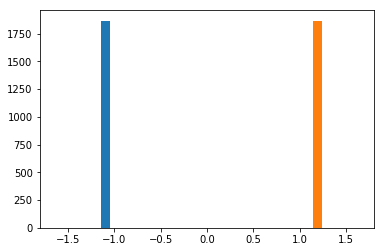

In [13]:
with sess.as_default():
    idet =det = EMD.bijector.inverse_log_det_jacobian(X,event_ndims=1).eval()
    print(det)
    plt.hist(det)

    rsq = np.linalg.norm(X,axis=1) ** 2
    val = EMD.bijector.inverse(X).eval()
    print (rsq.shape,val.shape)
    print (rsq)
    print (val)
    
    fdet = det = EMD.bijector.forward_log_det_jacobian(rsq,event_ndims=0).eval()
    print(det)
    plt.hist(det)
    
    L = idet + EMD.distribution.log_prob(rsq).eval()
#     L = L.eval()
    print (L)
    
    L = EMD.log_prob(X).eval()
    print (L)


In [14]:
# EMD.distribution.bi
EMD._override_event_shape

<tf.Tensor 'AsRadial_2/event_shape:0' shape=(1,) dtype=int32>

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,
          1.,   3.,   1.,   0.,   0.,   2.,   0.,   2.,   1.,   0.,   0.,
          2.,   0.,   1.,   0.,   3.,   6.,   1.,   1.,   1.,   1.,   4.,
          4.,   1.,   3.,   5.,   5.,   2.,   7.,   0.,   1.,   6.,   3.,
          1.,   5.,   7.,   5.,   6.,   3.,   5.,   5.,   8.,  11.,  17.,
          7.,  16.,  14.,   6.,  15.,  15.,  11.,  19.,  15.,  16.,  19.,
         21.,  21.,  32.,  30.,  54.,  73., 108., 131., 158., 181., 214.,
        544.]), array([-11.74314785, -11.66224   , -11.58133215, -11.50042431,
        -11.41951646, -11.33860861, -11.25770076, -11.17679291,
        -11.09588507, -11.01497722, -10.93406937, -10.85316152,
        -10.77225368, -10.69134583, -10.61043798, -10.52953013,
        -10.44862228, -10.36771444, -10.28680659, -10.20589874,

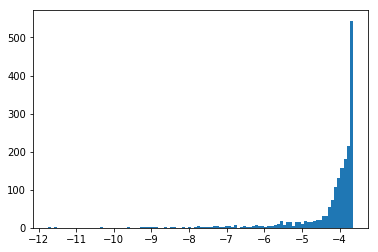

In [15]:
plt.hist(L.ravel(),100)

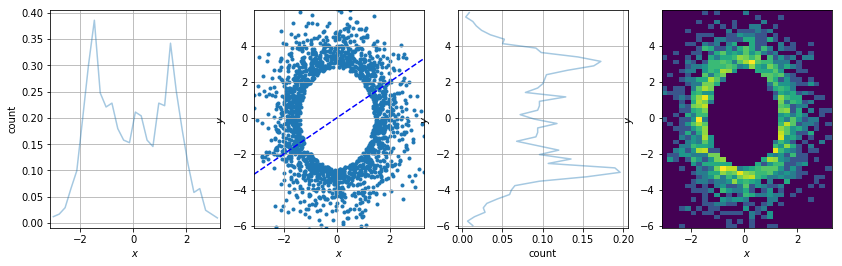

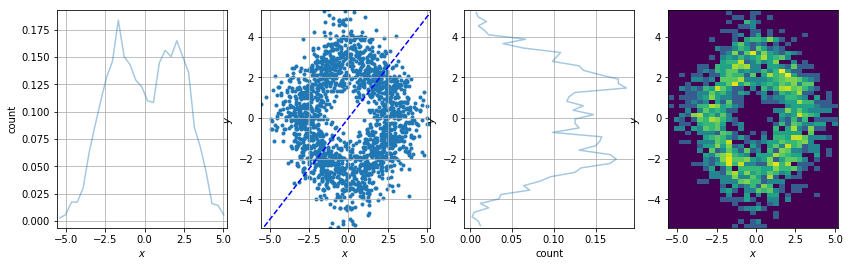

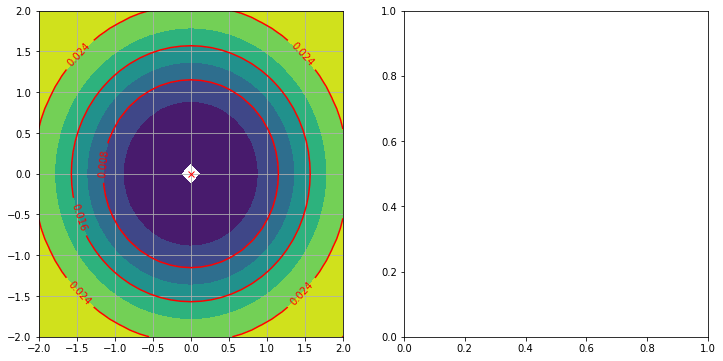

In [16]:
with sess.as_default():
#     emission.distribution.p
    Y = EMD.sample(len(X)).eval()

    pyvis.qc_2var(X.T[0],X.T[1])
    pyvis.qc_2var(Y.T[0],Y.T[1])
    f = EMD.prob
    L = f(X).eval()
#     f = emission.distribution.distribution.prob
    f = pyutil.wrapTFmethod(f,sess=sess)
    f = pyutil.arrayFunc2mgridFunc(f)
    pyvis.dmet_2d(f,vectorised=1);

In [17]:
bijectors.AffineLinearOperator

tensorflow_probability.python.bijectors.affine_linear_operator.AffineLinearOperator

In [18]:
# from tensorflow_probability.python import bijectors
# bijectors.Affine??

In [19]:
from tensorflow_probability.python import bijectors